In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

#import tensorflow as tf
#from tensorflow.keras import models, layers, optimizers, metrics
#from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [2]:
sns.set()

# Get the Data

In [3]:
path = "../raw_data/"

In [4]:
teste = os.path.join(path, "item_categories.csv")
teste

'../raw_data/item_categories.csv'

In [5]:
categories_ = pd.read_csv(os.path.join(path, "item_categories.csv"))
items_ = pd.read_csv(os.path.join(path, "items.csv"))
sales_ = pd.read_csv(os.path.join(path, "sales_train.csv"))
shops_ = pd.read_csv(os.path.join(path, "shops.csv"))
test_ = pd.read_csv(os.path.join(path, "test.csv"))
sample_ = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [6]:
categories_df = categories_.copy()
items_df = items_.copy()
shops_df = shops_.copy()
sales_df = sales_.copy()
test_df = test_.copy()
sample_df = sample_.copy()

In [7]:
sales_df["date"] = pd.to_datetime(sales_df.date, dayfirst=True)
sales_df = sales_df.merge(items_df[['item_id', 'item_category_id']], on='item_id')
sales_df['item_cnt_day'] = sales_df['item_cnt_day'].astype('int8')
sales_df['date_block_num'] = sales_df['date_block_num'].astype('int8')
sales_df['item_price'] = sales_df['item_price'].astype('float16')
sales_df.sort_values("date", inplace=True)

In [8]:
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
400417,2013-01-01,0,51,6622,347.00,1,30
130157,2013-01-01,0,7,1524,3000.00,1,29
867737,2013-01-01,0,19,18721,149.00,1,40
1004082,2013-01-01,0,54,15133,170.00,1,67
1004086,2013-01-01,0,41,15133,170.00,1,67
...,...,...,...,...,...,...,...
1788495,2015-10-31,33,58,3734,3400.00,1,23
2715396,2015-10-31,33,58,17748,288.25,1,70
1502745,2015-10-31,33,26,20949,5.00,3,71
2931438,2015-10-31,33,46,7223,4000.00,1,20


In [9]:
sales_df.dtypes

date                datetime64[ns]
date_block_num                int8
shop_id                      int64
item_id                      int64
item_price                 float16
item_cnt_day                  int8
item_category_id             int64
dtype: object

# Sorting the Data

## Group by Shop

### Sales Count per Week

In [10]:
shops_sales_per_week = pd.DataFrame()
shops_count_sales_per_week_dict = {}
shops_total_sales_per_week_dict = {}

for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].resample('W', on="date").sum()[["item_cnt_day"]]
    df.rename(columns = {'item_cnt_day':shop_id}, inplace=True)
    shops_count_sales_per_week_dict[shop_id] = df.shape[0]
    shops_total_sales_per_week_dict[shop_id] = df[[shop_id]].sum()[0]
    shops_sales_per_week = pd.concat([shops_sales_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
shops_sales_per_week

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,1056.0,586.0,411,222,641,NaN,820,799,586.0,NaN,...,967,755.0,488,627,3126.0,NaN,1146,NaN,NaN,589
2013-01-13,1268.0,598.0,312,212,485,NaN,798,549,309.0,NaN,...,799,595.0,367,513,2157.0,NaN,780,NaN,NaN,411
2013-01-20,1305.0,678.0,281,124,458,NaN,830,469,264.0,NaN,...,667,546.0,401,400,1669.0,NaN,526,NaN,NaN,429
2013-01-27,1258.0,694.0,142,146,348,NaN,821,480,243.0,NaN,...,725,600.0,330,349,1762.0,NaN,547,NaN,NaN,432
2013-02-03,1436.0,817.0,0,175,426,NaN,833,448,252.0,NaN,...,599,533.0,374,423,1885.0,NaN,555,NaN,NaN,374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,168,217,201,237.0,388,268,NaN,3187.0,...,200,14.0,195,258,NaN,854.0,281,456.0,336.0,148
2015-10-11,NaN,NaN,153,157,211,244.0,339,225,NaN,0.0,...,188,NaN,180,257,NaN,366.0,353,541.0,309.0,151
2015-10-18,NaN,NaN,178,146,186,257.0,487,323,NaN,-1.0,...,232,NaN,212,243,NaN,466.0,249,527.0,307.0,170


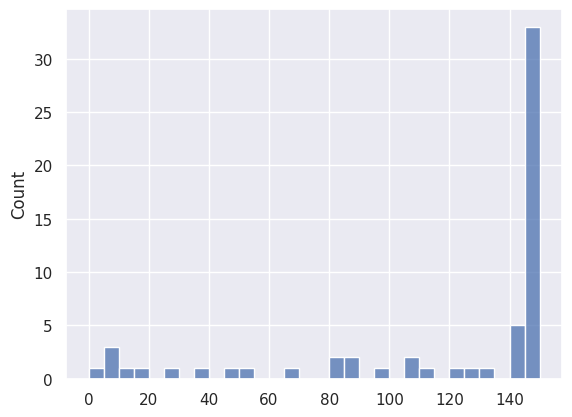

In [11]:
sns.histplot(shops_count_sales_per_week_dict, binwidth=5, binrange=(0, 148));

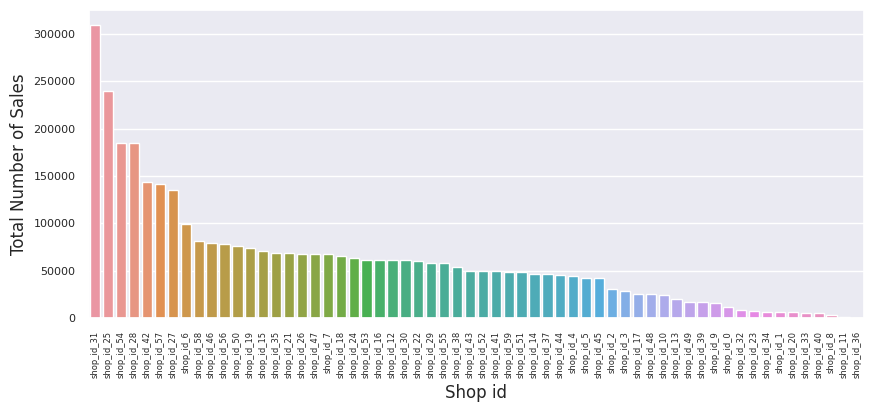

In [12]:
shops_total_sales_per_week_df = pd.DataFrame(shops_total_sales_per_week_dict, index=[0])
shops_total_sales_per_week_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(10,4))
sns.barplot(shops_total_sales_per_week_df)
plt.xlabel("Shop id")
plt.ylabel("Total Number of Sales")
plt.tick_params(axis='x', labelsize=6, rotation=90)
plt.tick_params(axis='y', labelsize=8)

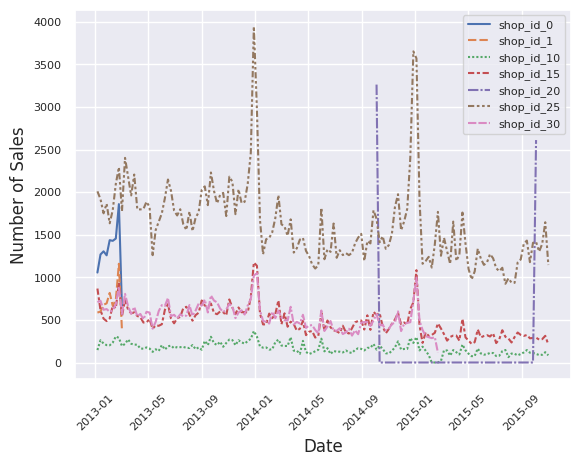

In [13]:
sns.lineplot(data=[
    shops_sales_per_week.shop_id_0,
    shops_sales_per_week.shop_id_1,
    shops_sales_per_week.shop_id_10,
    shops_sales_per_week.shop_id_15,
    shops_sales_per_week.shop_id_20,
    shops_sales_per_week.shop_id_25,
    shops_sales_per_week.shop_id_30
])
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

### Sales Values per Week

In [14]:
shops_values_per_week = pd.DataFrame()
shops_total_values_per_week_dict = {}

for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].resample('W', on="date").sum()[["item_price"]]
    df.rename(columns = {'item_price':shop_id}, inplace=True)
    shops_total_values_per_week_dict[shop_id] = df[[shop_id]].sum()[0]
    shops_values_per_week = pd.concat([shops_values_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
shops_values_per_week

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,541141.0,306571.0,339015.5000,163664.50,394066.00000,NaN,538795.1250,519415.375,377135.0,NaN,...,701772.0625,262656.0,321967.1875,393540.0,1.753411e+06,NaN,631323.5000,NaN,NaN,471726.5625
2013-01-13,603629.0,267480.0,287780.8750,156213.00,331071.62500,NaN,617301.1875,406003.000,169523.0,NaN,...,594615.5000,234896.0,221581.0000,309680.0,1.245886e+06,NaN,509281.8125,NaN,NaN,318045.5000
2013-01-20,525870.0,319326.0,276500.8125,96326.50,293773.00000,NaN,552376.2500,300023.625,175855.0,NaN,...,605724.0000,150807.0,298933.5000,321255.5,9.543516e+05,NaN,286361.5000,NaN,NaN,352183.0000
2013-01-27,485367.0,288008.0,125619.5000,83605.00,205303.50000,NaN,515650.2500,337844.000,146889.5,NaN,...,543594.0000,179399.0,197321.5000,266209.5,8.723958e+05,NaN,305930.4375,NaN,NaN,246370.4375
2013-02-03,749832.0,386438.0,0.0000,137310.25,267520.50000,NaN,475438.7500,320157.750,130795.0,NaN,...,434565.0000,126742.0,191751.0000,254176.0,8.948352e+05,NaN,299002.1250,NaN,NaN,249678.6250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,255602.2500,237386.00,158169.25000,225973.500,407424.0000,373911.000,NaN,1249850.0,...,293483.0000,15839.0,306469.0000,347241.0,NaN,272515.0,281515.0000,395904.0,434161.96875,169202.0000
2015-10-11,NaN,NaN,225907.0000,154506.00,137015.90625,210525.625,358108.0000,229201.000,NaN,0.0,...,315684.5000,NaN,151875.0000,268835.0,NaN,218647.0,349021.0000,537966.0,357558.00000,142764.0000
2015-10-18,NaN,NaN,217150.0000,114717.50,123172.00000,248638.500,499052.5000,404496.875,NaN,3800.0,...,197641.0000,NaN,195599.5000,172841.0,NaN,276257.0,329935.0000,442278.0,370708.00000,166274.0000


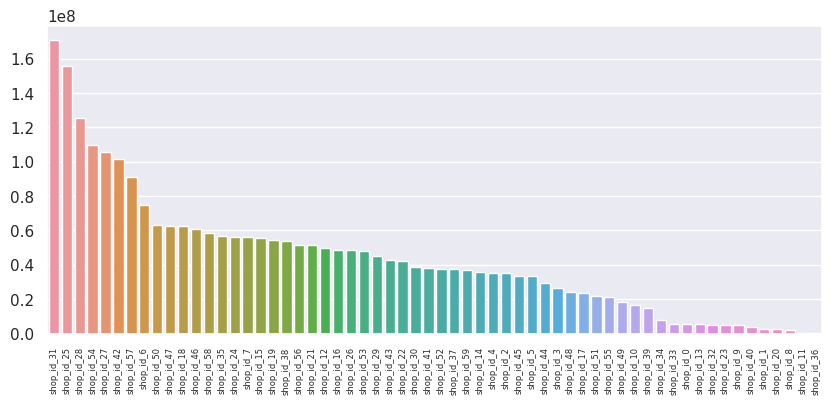

In [15]:
shops_values_per_week_df = pd.DataFrame(shops_total_values_per_week_dict, index=[0])
shops_values_per_week_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(10,4))
sns.barplot(shops_values_per_week_df)
#plt.xlabel("Date")
#plt.ylabel("Number of Sells")
plt.tick_params(axis='x', labelsize=6, rotation=90)
#plt.tick_params(axis='y', labelsize=8)

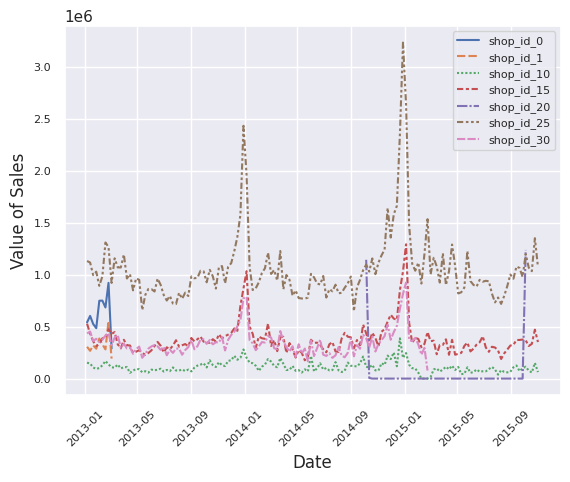

In [16]:
sns.lineplot(data=[
    shops_values_per_week.shop_id_0,
    shops_values_per_week.shop_id_1,
    shops_values_per_week.shop_id_10,
    shops_values_per_week.shop_id_15,
    shops_values_per_week.shop_id_20,
    shops_values_per_week.shop_id_25,
    shops_values_per_week.shop_id_30
])
plt.xlabel("Date")
plt.ylabel("Value of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

## Group by Category

### Sales Count per Week

In [17]:
cats_sales_per_week = pd.DataFrame()
cats_count_sales_per_week_dict = {}
cats_total_sales_per_week_dict = {}

for id in range(categories_df.shape[0]):
    cat_id = f"cat_id_{id}"
    df = sales_df[sales_df['item_category_id'] == id].resample('W', on="date").sum()[["item_cnt_day"]]
    df.rename(columns = {'item_cnt_day':cat_id}, inplace=True)
    cats_count_sales_per_week_dict[cat_id] = df.shape[0]
    cats_total_sales_per_week_dict[cat_id] = df[[cat_id]].sum()[0]
    cats_sales_per_week = pd.concat([cats_sales_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
cats_sales_per_week

,cat_id_0,cat_id_1,cat_id_2,cat_id_3,cat_id_4,cat_id_5,cat_id_6,cat_id_7,cat_id_8,cat_id_9,...,cat_id_74,cat_id_75,cat_id_76,cat_id_77,cat_id_78,cat_id_79,cat_id_80,cat_id_81,cat_id_82,cat_id_83
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,NaN,NaN,468,144,85.0,233,245,NaN,NaN,NaN,...,NaN,647,NaN,127,NaN,27,NaN,41.0,310.0,319
2013-01-13,1.0,1.0,303,93,30.0,150,206,NaN,NaN,21.0,...,NaN,712,NaN,122,NaN,21,NaN,38.0,325.0,201
2013-01-20,0.0,0.0,276,83,57.0,103,194,NaN,NaN,55.0,...,NaN,724,NaN,94,NaN,13,NaN,36.0,318.0,144
2013-01-27,0.0,0.0,241,87,56.0,99,156,NaN,NaN,34.0,...,NaN,588,NaN,87,NaN,56,NaN,43.0,289.0,164
2013-02-03,0.0,0.0,232,69,50.0,71,145,NaN,NaN,46.0,...,NaN,623,NaN,116,NaN,44,NaN,40.0,275.0,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,23,246,NaN,11,50,57.0,380.0,321.0,...,2.0,325,42.0,0,16.0,145,401.0,NaN,NaN,87
2015-10-11,NaN,NaN,21,239,NaN,8,64,40.0,0.0,81.0,...,1.0,171,40.0,5,10.0,136,NaN,NaN,NaN,73
2015-10-18,NaN,NaN,17,260,NaN,7,46,38.0,-1.0,96.0,...,1.0,169,45.0,3,21.0,119,NaN,NaN,NaN,81


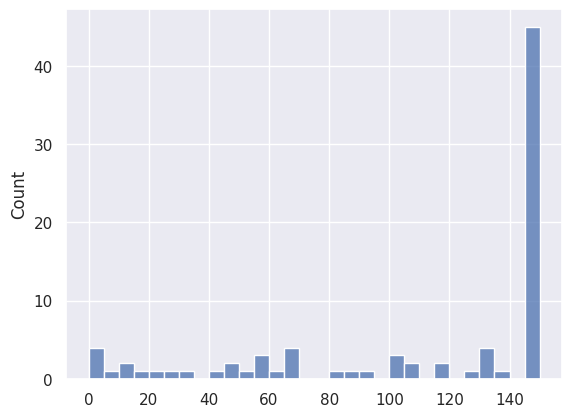

In [18]:
sns.histplot(cats_count_sales_per_week_dict, binwidth=5, binrange=(0, 148));

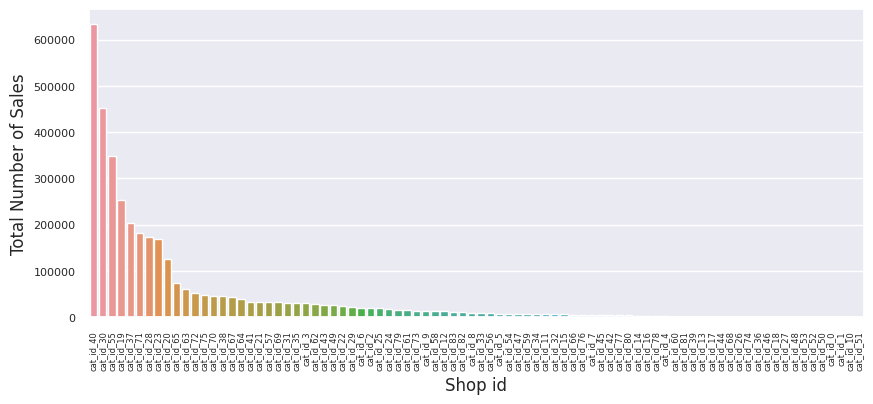

In [19]:
cats_total_sales_per_week_df = pd.DataFrame(cats_total_sales_per_week_dict, index=[0])
cats_total_sales_per_week_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(10,4))
sns.barplot(cats_total_sales_per_week_df)
plt.xlabel("Shop id")
plt.ylabel("Total Number of Sales")
plt.tick_params(axis='x', labelsize=6, rotation=90)
plt.tick_params(axis='y', labelsize=8)

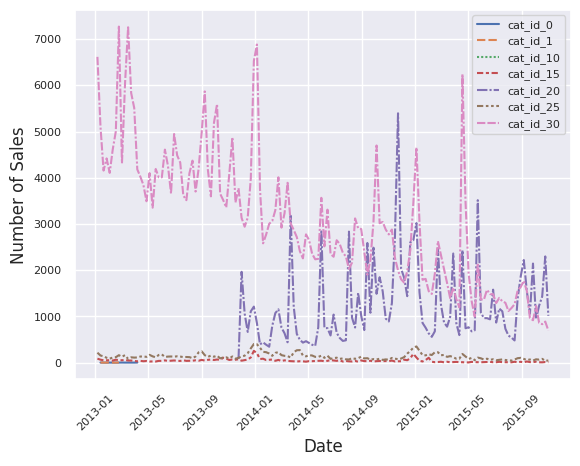

In [20]:
sns.lineplot(data=[
    cats_sales_per_week.cat_id_0,
    cats_sales_per_week.cat_id_1,
    cats_sales_per_week.cat_id_10,
    cats_sales_per_week.cat_id_15,
    cats_sales_per_week.cat_id_20,
    cats_sales_per_week.cat_id_25,
    cats_sales_per_week.cat_id_30
])
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

### Sales Values per Week

In [21]:
cats_values_per_week = pd.DataFrame()
cats_total_values_per_week_dict = {}

for id in range(categories_df.shape[0]):
    cat_id = f"cat_id_{id}"
    df = sales_df[sales_df['item_category_id'] == id].resample('W', on="date").sum()[["item_price"]]
    df.rename(columns = {'item_price':cat_id}, inplace=True)
    cats_total_values_per_week_dict[cat_id] = df[[cat_id]].sum()[0]
    cats_values_per_week = pd.concat([cats_values_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
cats_values_per_week

,cat_id_0,cat_id_1,cat_id_2,cat_id_3,cat_id_4,cat_id_5,cat_id_6,cat_id_7,cat_id_8,cat_id_9,...,cat_id_74,cat_id_75,cat_id_76,cat_id_77,cat_id_78,cat_id_79,cat_id_80,cat_id_81,cat_id_82,cat_id_83
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,NaN,NaN,812946.0,44590.500,75362.0,216865.875,362744.5,NaN,NaN,NaN,...,NaN,881089.5,NaN,24588.000,NaN,10090.000,NaN,7428.0,3877.0,12120.9375
2013-01-13,148.0,148.0,559555.5,36031.750,35179.0,154565.500,287245.5,NaN,NaN,9092.000000,...,NaN,906588.5,NaN,21896.000,NaN,12218.500,NaN,5178.0,4111.0,9728.0000
2013-01-20,0.0,0.0,570507.0,32155.000,46328.0,101045.000,324888.0,NaN,NaN,11144.750000,...,NaN,936847.5,NaN,15153.000,NaN,9060.000,NaN,4564.0,4210.0,6996.3750
2013-01-27,0.0,0.0,514723.0,34371.000,50970.0,98602.250,265928.0,NaN,NaN,11898.000000,...,NaN,843682.0,NaN,13910.125,NaN,7170.000,NaN,6501.0,3602.0,7520.0000
2013-02-03,0.0,0.0,464550.0,25903.000,32788.0,66969.000,211210.0,NaN,NaN,7039.312500,...,NaN,933673.0,NaN,19429.000,NaN,19100.000,NaN,5254.0,3583.0,5509.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,65684.0,506223.000,NaN,7089.000,125921.0,120073.0,24659.0,8939.375000,...,4980.0,241209.0,52559.0,0.000,5177.0,120483.250,190486.0,NaN,NaN,8640.0000
2015-10-11,NaN,NaN,50812.0,469556.375,NaN,4992.000,164193.0,94166.0,0.0,10506.625000,...,3990.0,372272.0,40149.0,1055.000,3248.0,109999.125,NaN,NaN,NaN,5811.0000
2015-10-18,NaN,NaN,54446.0,439855.000,NaN,4393.000,120645.0,103501.0,1500.0,17528.750000,...,3990.0,328070.0,70668.0,657.000,6731.0,78772.875,NaN,NaN,NaN,7445.0000


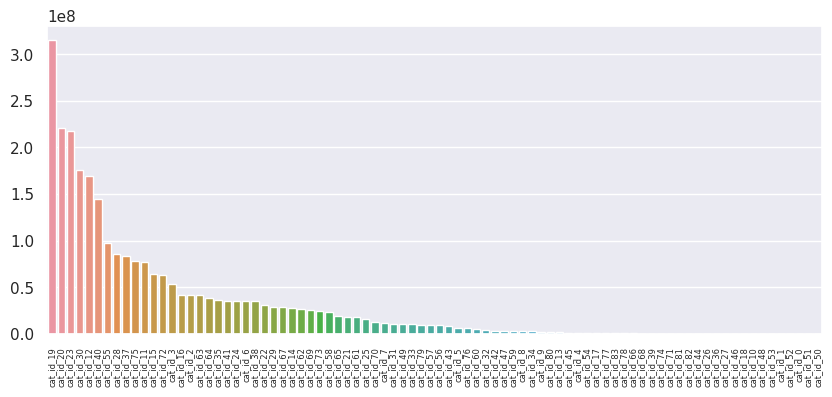

In [22]:
cats_total_values_per_week_df = pd.DataFrame(cats_total_values_per_week_dict, index=[0])
cats_total_values_per_week_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(10,4))
sns.barplot(cats_total_values_per_week_df)
#plt.xlabel("Date")
#plt.ylabel("Number of Sells")
plt.tick_params(axis='x', labelsize=6, rotation=90)
#plt.tick_params(axis='y', labelsize=8)

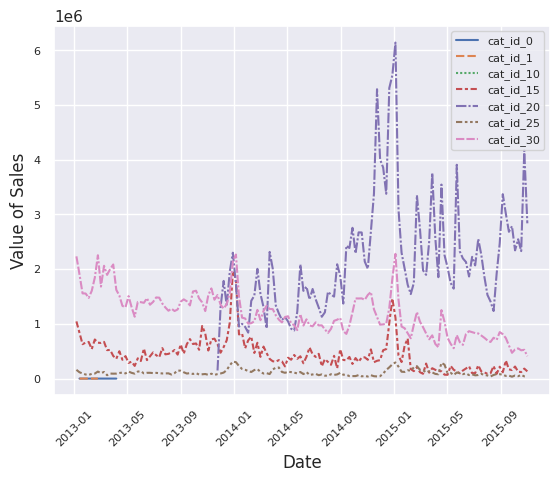

In [23]:
sns.lineplot(data=[
    cats_values_per_week.cat_id_0,
    cats_values_per_week.cat_id_1,
    cats_values_per_week.cat_id_10,
    cats_values_per_week.cat_id_15,
    cats_values_per_week.cat_id_20,
    cats_values_per_week.cat_id_25,
    cats_values_per_week.cat_id_30
])
plt.xlabel("Date")
plt.ylabel("Value of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

## Group by item

### Sales Count per Week

### Sales Values per Week

## Total

In [24]:
total_shops_sales_per_week = shops_sales_per_week.fillna(0).sum(axis=1)
total_shops_values_per_week = shops_values_per_week.fillna(0).sum(axis=1)
total_cats_sales_per_week = cats_sales_per_week.fillna(0).sum(axis=1)
total_cats_values_per_week = cats_values_per_week.fillna(0).sum(axis=1)

In [25]:
total_shops_sales_per_week_df = pd.DataFrame(total_shops_sales_per_week)
total_shops_values_per_week_df = pd.DataFrame(total_shops_values_per_week)
total_cats_sales_per_week_df = pd.DataFrame(total_cats_sales_per_week)
total_cats_values_per_week_df = pd.DataFrame(total_cats_values_per_week)

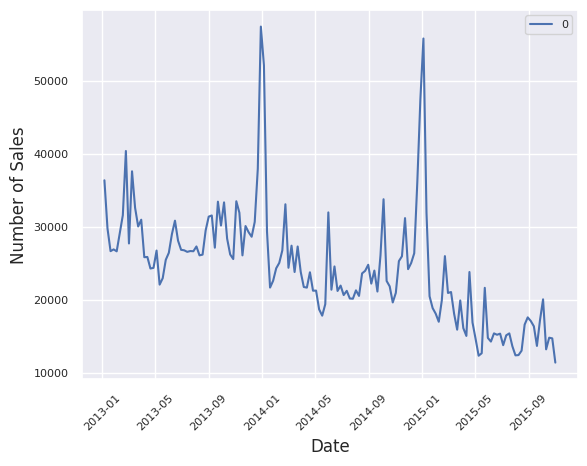

In [26]:
sns.lineplot(data=[
    total_shops_sales_per_week_df[0],
    total_cats_sales_per_week_df[0]
])
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

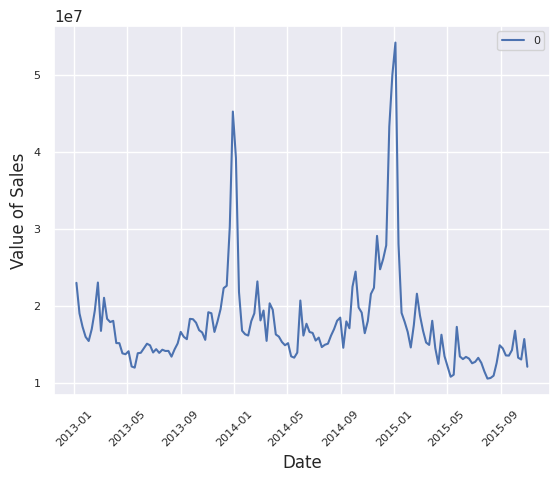

In [27]:
sns.lineplot(data=[
    total_shops_values_per_week_df[0],
    total_cats_values_per_week_df[0]
])
plt.xlabel("Date")
plt.ylabel("Value of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

# Model Prophet

## Model Setup

In [47]:
# plot graph with train test and predict
def plot_forecast(train_df, test_df, forecast, horizon=29, lower=False, upper=False):
    plt.figure(figsize=(15, 8))
    plt.plot(train_df['ds'], train_df['y'], label="Train")
    plt.plot(test_df['ds'], test_df['y'], label="Test")
    plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="Pred")
    if lower:
        plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat_lower'], label="Lower")
    if upper:
        plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat_upper'], label="Upper")
    plt.legend(loc="best")
    plt.show()

In [128]:
# plot graph with train test and predict
def plot_forecast(prophet_dict: dict, lower=False, upper=False):
    plt.figure(figsize=(15, 8))
    plt.plot(prophet_dict['train']['ds'], prophet_dict['train']['y'], label="Train")
    plt.plot(prophet_dict['test']['ds'], prophet_dict['test']['y'], label="Test")
    plt.plot(
        prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
        prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat'],
        label="Pred")
    if lower:
        plt.plot(
            prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
            prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_lower'],
            label="Lower")
    if upper:
        plt.plot(prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
                 prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_upper'],
                 label="Upper")
    plt.legend(loc="best")
    plt.show()

In [116]:
# function to split the data between train and test
def set_train_data(df):
    df = df.reset_index()
    df.columns = ['ds', 'y']
    train = df.iloc[:127]
    test = df.iloc[127:]
    return train, test

In [188]:
# rum the Prophet model
def fit_prophet(data, seas_scale=10, inter_w=0.80, horizon=29, freq='W'):
    train_df, test_df = set_train_data(data)
    
    model = Prophet(
        seasonality_mode='multiplicative', # or 'additive'
        seasonality_prior_scale=seas_scale, # default 10, smaller values dampen the seasonality
        interval_width=inter_w, # deaful 0.8, if mcmc < 0 will be integrated over all model parameters
        growth='linear', # is the default
        #yearly_seasonality=False, # default 'auto'
        #weekly_seasonality=True, # default 'auto'
        #daily_seasonality=False, # default 'auto'
        mcmc_samples=0, # default 0, if greater than 0, will do full Bayesian inference
    )
    model = model.fit(train_df)
    
    forecast = future_preds(model, horizon, freq)
    
    prophet_dict = {'model':model,
        'forecast':forecast,
        'train':train_df,
        'test':test_df,
        'horizon':horizon
    }
    
    return prophet_dict

In [130]:
# make future predictions
def future_preds(model, horizon=29, freq='W'):
    future = model.make_future_dataframe(periods=horizon, freq=freq, )
    forecast = model.predict(future)
    # forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    return forecast    

## Total (Shop / Category)

### Fitting the Data and Making Future Predictions

In [179]:
# total_Shops_Number_sales_per_week
prophet_total_shops_sales_per_week = fit_prophet(
    total_shops_sales_per_week_df,
    seas_scale=100,
    inter_w=0.80,
    horizon=29,
    freq='W'
)

# total_Shops_Values_per_week
prophet_total_shops_values_per_week = fit_prophet(
    total_shops_values_per_week_df,
    seas_scale=100,
    inter_w=0.80,
    horizon=29,
    freq='W'
)

19:09:37 - cmdstanpy - INFO - Chain [1] start processing
19:09:37 - cmdstanpy - INFO - Chain [1] done processing
19:09:37 - cmdstanpy - INFO - Chain [1] start processing
19:09:37 - cmdstanpy - INFO - Chain [1] done processing


In [155]:
prophet_total_shops_sales_per_week['forecast'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(8)

,ds,yhat,yhat_lower,yhat_upper
148,2015-11-08,20778.695287,16164.871526,25094.602819
149,2015-11-15,23106.399873,18824.462468,27762.701871
150,2015-11-22,22282.072220,17635.787567,26538.406174
151,2015-11-29,19254.129606,15115.531784,23480.507253
152,2015-12-06,18077.670805,13727.720424,22575.404744
153,2015-12-13,21865.736727,17553.891875,26552.980655
154,2015-12-20,29124.437376,24431.401445,33708.786967
155,2015-12-27,34482.752631,30021.599735,39093.284727


In [123]:
prophet_total_shops_values_per_week['forecast'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(8)

,ds,yhat,yhat_lower,yhat_upper
148,2015-11-08,1.705679e+07,1.373006e+07,2.044394e+07
149,2015-11-15,1.959115e+07,1.600158e+07,2.269089e+07
150,2015-11-22,1.968361e+07,1.655478e+07,2.314459e+07
151,2015-11-29,1.805334e+07,1.461978e+07,2.173655e+07
152,2015-12-06,1.827942e+07,1.466589e+07,2.184278e+07
153,2015-12-13,2.314158e+07,1.971283e+07,2.646860e+07
154,2015-12-20,3.107983e+07,2.763942e+07,3.453881e+07
155,2015-12-27,3.672474e+07,3.340613e+07,4.022423e+07


### Plotting the forecast

#### Shops Total Number of Sales per Week

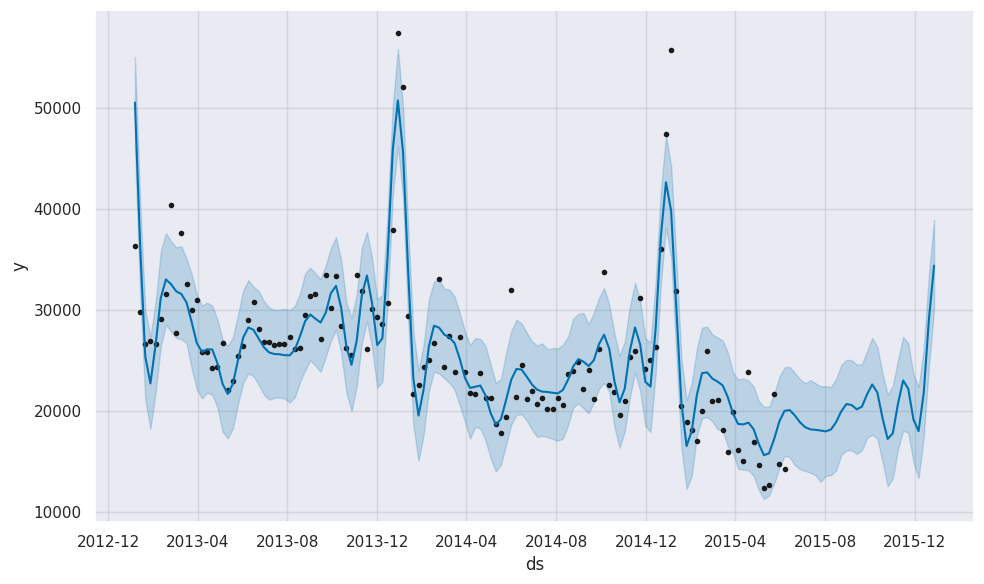

In [175]:
prophet_total_shops_sales_per_week['model'].plot(prophet_total_shops_sales_per_week['forecast']);

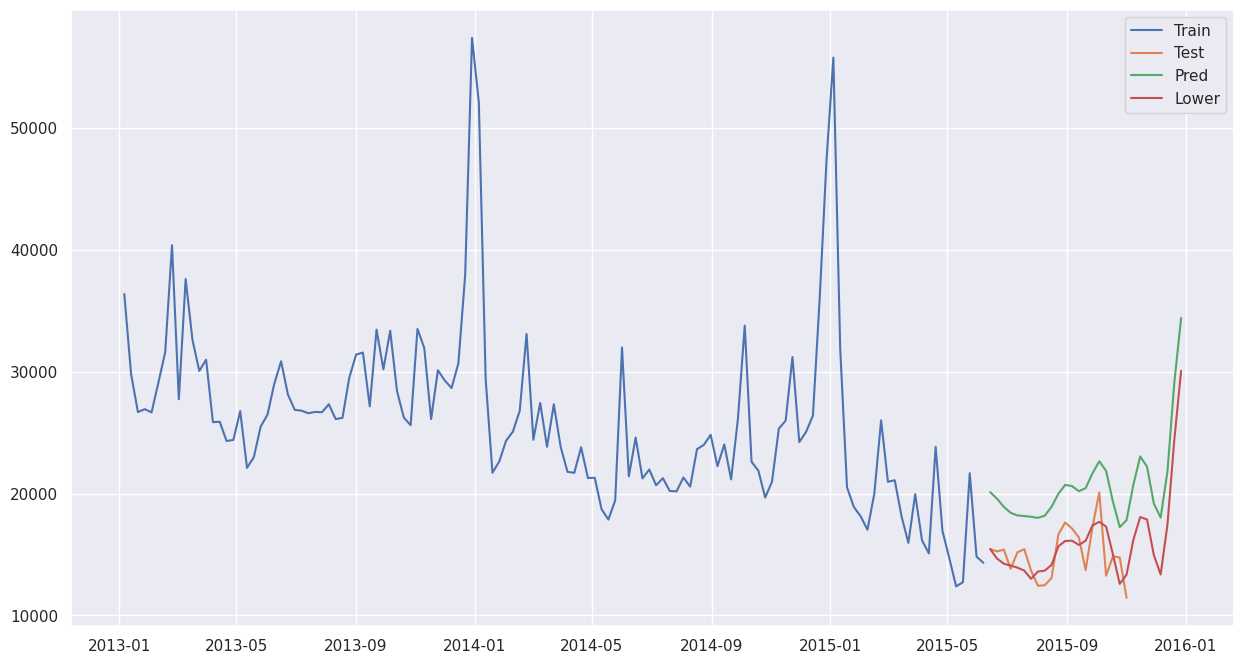

In [176]:
plot_forecast(prophet_total_shops_sales_per_week, lower=True)

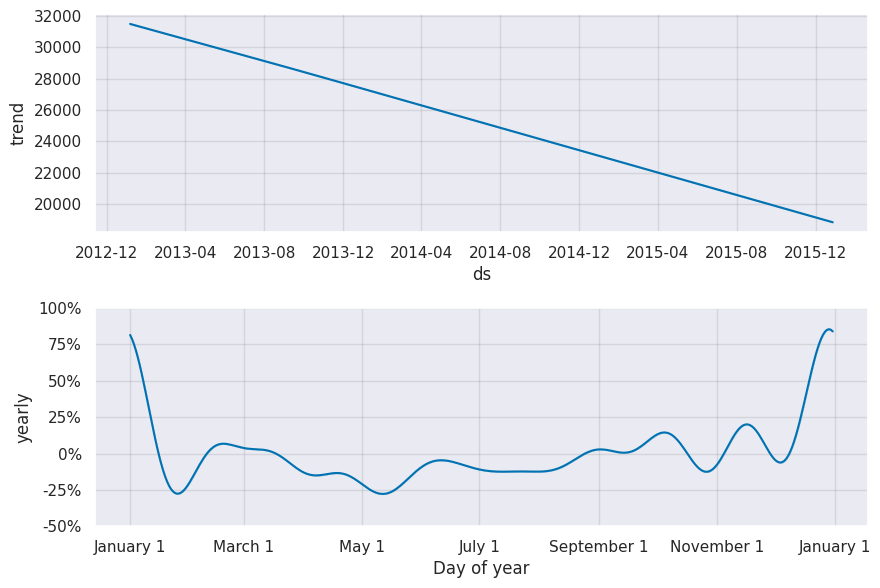

In [183]:
prophet_total_shops_sales_per_week['model'].plot_components(prophet_total_shops_sales_per_week['forecast']);

#### Shops Total Value of Sales per Week

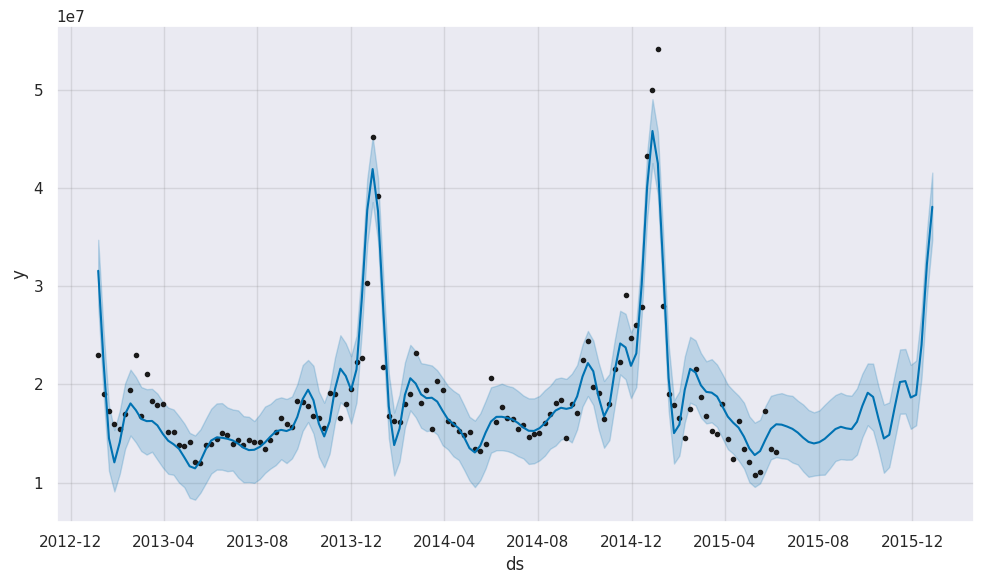

In [180]:
prophet_total_shops_values_per_week['model'].plot(prophet_total_shops_values_per_week['forecast']);

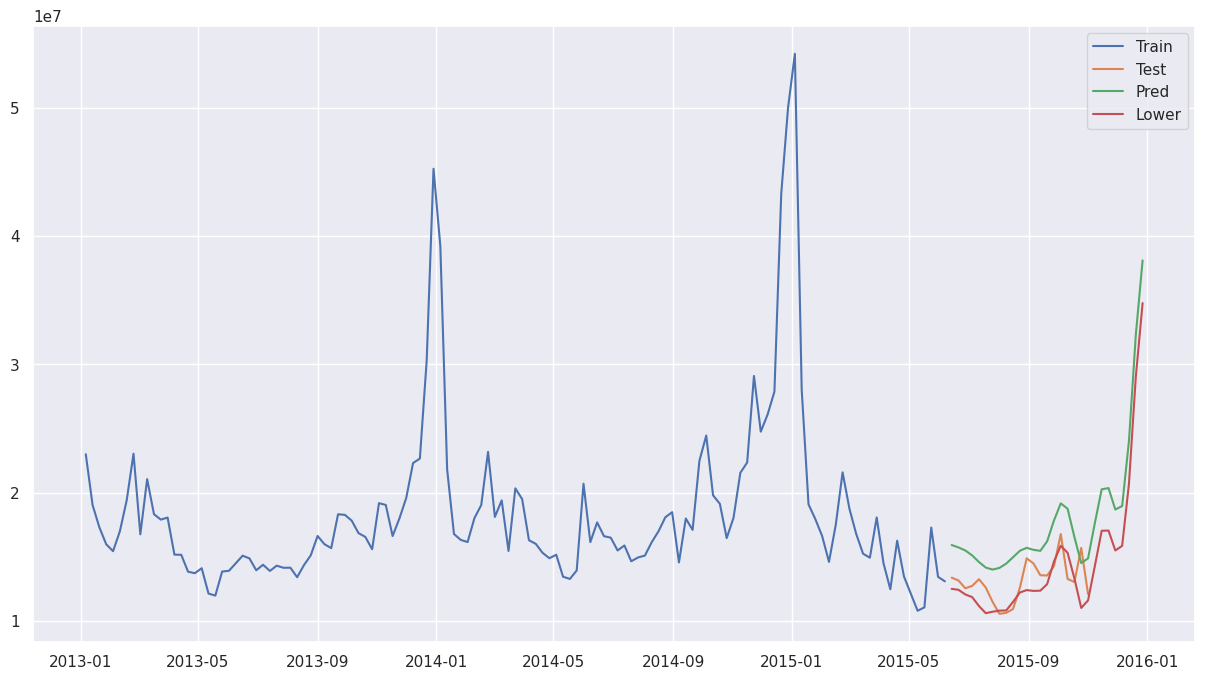

In [181]:
plot_forecast(prophet_total_shops_values_per_week, lower=True)

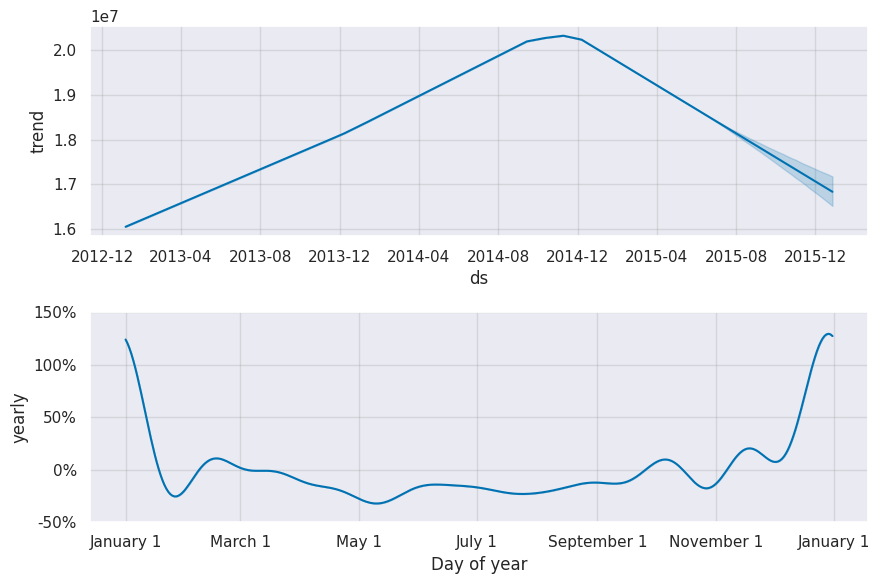

In [182]:
prophet_total_shops_values_per_week['model'].plot_components(prophet_total_shops_values_per_week['forecast']);

### Evaluating the model with cross-validation

In [53]:
cv_results = cross_validation(
    model=model_tSNw,
    initial=f'{4 * 7 * 6} days', # six month
    horizon=f'{4 * 7} days', # one month
    period='14 days'
)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/50 [00:00<?, ?it/s]

17:36:01 - cmdstanpy - INFO - Chain [1] start processing
17:36:01 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing
17:36:03 - cmdstanpy - INFO - Chain [1] start processing
17:36:03 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:05 - cmdstanpy - INFO - Chain [1] start processing
17:36:05 - cmdstanpy - INFO - Chain [1] done processing
17:36:05 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1]

In [54]:
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-06-30,16572.544794,13849.731464,19363.893175,26880.0,2013-06-23
1,2013-07-07,-4552.025400,-7178.955262,-1928.822188,26813.0,2013-06-23
2,2013-07-14,-24721.599368,-27377.303986,-22248.632557,26602.0,2013-06-23
3,2013-07-21,-26940.254379,-29696.263378,-24184.868032,26711.0,2013-06-23
4,2013-07-14,32529.731462,29954.226206,35334.029170,26602.0,2013-07-07
...,...,...,...,...,...,...
195,2015-05-24,18105.957436,13860.137926,22453.344135,21681.0,2015-04-26
196,2015-05-17,15891.032891,11507.274159,20395.428825,12730.0,2015-05-10
197,2015-05-24,17693.918508,13039.683408,22200.987364,21681.0,2015-05-10
198,2015-05-31,19854.256545,14898.858747,24291.037817,14826.0,2015-05-10


In [55]:
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,1.240092e+08,11135.943187,6036.166710,0.217369,0.140415,0.214234,0.60
1,14 days,1.212271e+09,34817.681550,13742.074950,0.501800,0.190400,0.385531,0.52
2,21 days,5.386914e+09,73395.595922,23574.939439,0.856493,0.186949,0.452855,0.50
3,28 days,1.206196e+10,109826.948644,30584.667947,1.090090,0.211270,0.458272,0.46


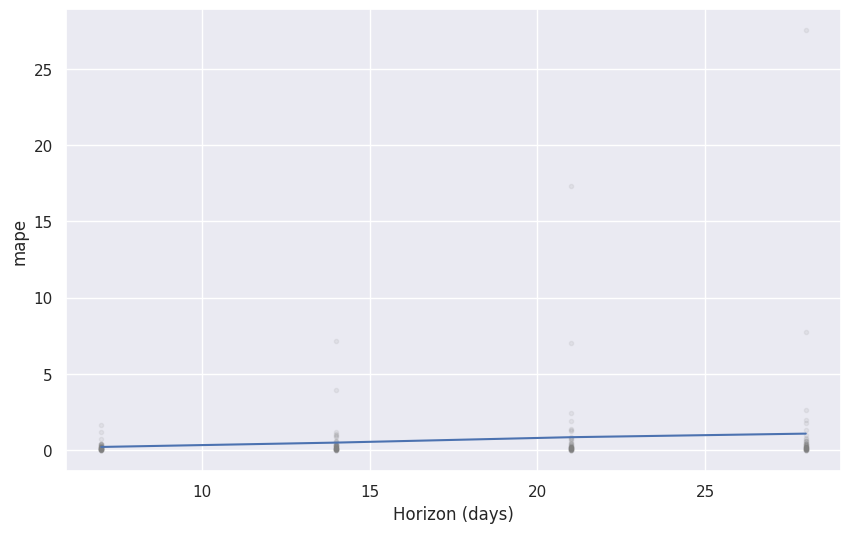

In [56]:
plot_cross_validation_metric(cv_results, metric='mape');

##  Shop

In [250]:
id_0

,shop_id_0
date,
2013-01-06,1056.0
2013-01-13,1268.0
2013-01-20,1305.0
2013-01-27,1258.0
2013-02-03,1436.0
...,...
2015-10-04,0.0
2015-10-11,0.0
2015-10-18,0.0


In [253]:
shops_sales_per_week['shop_id_0'].fillna(0)

date
2013-01-06    1056.0
2013-01-13    1268.0
2013-01-20    1305.0
2013-01-27    1258.0
2013-02-03    1436.0
               ...  
2015-10-04       0.0
2015-10-11       0.0
2015-10-18       0.0
2015-10-25       0.0
2015-11-01       0.0
Freq: W-SUN, Name: shop_id_0, Length: 148, dtype: float64

In [259]:
shops_id_list = shops_sales_per_week.columns.to_list()
predict_shops_sales_count = {}
for shop in shops_id_list:
    print(shop)
    df = shops_sales_per_week[shop].fillna(0)
    prophet =  fit_prophet(
        data=df,
        seas_scale=10,
        inter_w=0.80,
        horizon=25,
        freq='W'
    )
    predict_shops_sales_count[shop] = prophet['forecast']['yhat'].tail(4)

20:14:44 - cmdstanpy - INFO - Chain [1] start processing
20:14:44 - cmdstanpy - INFO - Chain [1] done processing


shop_id_0


20:14:45 - cmdstanpy - INFO - Chain [1] start processing
20:14:45 - cmdstanpy - INFO - Chain [1] done processing


shop_id_1


20:14:45 - cmdstanpy - INFO - Chain [1] start processing
20:14:45 - cmdstanpy - INFO - Chain [1] done processing


shop_id_2


20:14:46 - cmdstanpy - INFO - Chain [1] start processing
20:14:46 - cmdstanpy - INFO - Chain [1] done processing


shop_id_3


20:14:47 - cmdstanpy - INFO - Chain [1] start processing
20:14:47 - cmdstanpy - INFO - Chain [1] done processing


shop_id_4


20:14:47 - cmdstanpy - INFO - Chain [1] start processing
20:14:47 - cmdstanpy - INFO - Chain [1] done processing


shop_id_5


20:14:48 - cmdstanpy - INFO - Chain [1] start processing
20:14:48 - cmdstanpy - INFO - Chain [1] done processing


shop_id_6


20:14:48 - cmdstanpy - INFO - Chain [1] start processing
20:14:48 - cmdstanpy - INFO - Chain [1] done processing


shop_id_7


20:14:49 - cmdstanpy - INFO - Chain [1] start processing
20:14:49 - cmdstanpy - INFO - Chain [1] done processing


shop_id_8


20:14:50 - cmdstanpy - INFO - Chain [1] start processing
20:14:50 - cmdstanpy - INFO - Chain [1] done processing


shop_id_9


20:14:50 - cmdstanpy - INFO - Chain [1] start processing
20:14:50 - cmdstanpy - INFO - Chain [1] done processing


shop_id_10


20:14:51 - cmdstanpy - INFO - Chain [1] start processing
20:14:51 - cmdstanpy - INFO - Chain [1] done processing


shop_id_11


20:14:51 - cmdstanpy - INFO - Chain [1] start processing
20:14:51 - cmdstanpy - INFO - Chain [1] done processing


shop_id_12


20:14:52 - cmdstanpy - INFO - Chain [1] start processing
20:14:52 - cmdstanpy - INFO - Chain [1] done processing


shop_id_13


20:14:52 - cmdstanpy - INFO - Chain [1] start processing
20:14:52 - cmdstanpy - INFO - Chain [1] done processing


shop_id_14


20:14:53 - cmdstanpy - INFO - Chain [1] start processing
20:14:53 - cmdstanpy - INFO - Chain [1] done processing


shop_id_15


20:14:53 - cmdstanpy - INFO - Chain [1] start processing
20:14:53 - cmdstanpy - INFO - Chain [1] done processing


shop_id_16


20:14:54 - cmdstanpy - INFO - Chain [1] start processing
20:14:54 - cmdstanpy - INFO - Chain [1] done processing


shop_id_17


20:14:54 - cmdstanpy - INFO - Chain [1] start processing
20:14:54 - cmdstanpy - INFO - Chain [1] done processing


shop_id_18


20:14:55 - cmdstanpy - INFO - Chain [1] start processing
20:14:55 - cmdstanpy - INFO - Chain [1] done processing


shop_id_19


20:14:56 - cmdstanpy - INFO - Chain [1] start processing
20:14:56 - cmdstanpy - INFO - Chain [1] done processing


shop_id_20


20:14:56 - cmdstanpy - INFO - Chain [1] start processing
20:14:56 - cmdstanpy - INFO - Chain [1] done processing


shop_id_21


20:14:57 - cmdstanpy - INFO - Chain [1] start processing
20:14:57 - cmdstanpy - INFO - Chain [1] done processing


shop_id_22


20:14:57 - cmdstanpy - INFO - Chain [1] start processing
20:14:57 - cmdstanpy - INFO - Chain [1] done processing


shop_id_23


20:14:57 - cmdstanpy - INFO - Chain [1] start processing
20:14:57 - cmdstanpy - INFO - Chain [1] done processing


shop_id_24


20:14:58 - cmdstanpy - INFO - Chain [1] start processing
20:14:58 - cmdstanpy - INFO - Chain [1] done processing


shop_id_25


20:14:59 - cmdstanpy - INFO - Chain [1] start processing
20:14:59 - cmdstanpy - INFO - Chain [1] done processing


shop_id_26


20:14:59 - cmdstanpy - INFO - Chain [1] start processing
20:14:59 - cmdstanpy - INFO - Chain [1] done processing


shop_id_27


20:15:00 - cmdstanpy - INFO - Chain [1] start processing
20:15:00 - cmdstanpy - INFO - Chain [1] done processing


shop_id_28


20:15:00 - cmdstanpy - INFO - Chain [1] start processing
20:15:00 - cmdstanpy - INFO - Chain [1] done processing


shop_id_29


20:15:01 - cmdstanpy - INFO - Chain [1] start processing
20:15:01 - cmdstanpy - INFO - Chain [1] done processing


shop_id_30


20:15:01 - cmdstanpy - INFO - Chain [1] start processing
20:15:01 - cmdstanpy - INFO - Chain [1] done processing


shop_id_31


20:15:02 - cmdstanpy - INFO - Chain [1] start processing
20:15:02 - cmdstanpy - INFO - Chain [1] done processing


shop_id_32


20:15:02 - cmdstanpy - INFO - Chain [1] start processing
20:15:02 - cmdstanpy - INFO - Chain [1] done processing


shop_id_33


20:15:03 - cmdstanpy - INFO - Chain [1] start processing
20:15:03 - cmdstanpy - INFO - Chain [1] done processing


shop_id_34


20:15:03 - cmdstanpy - INFO - Chain [1] start processing
20:15:03 - cmdstanpy - INFO - Chain [1] done processing


shop_id_35
shop_id_36


20:15:05 - cmdstanpy - INFO - Chain [1] start processing
20:15:05 - cmdstanpy - INFO - Chain [1] done processing


shop_id_37


20:15:05 - cmdstanpy - INFO - Chain [1] start processing
20:15:05 - cmdstanpy - INFO - Chain [1] done processing


shop_id_38


20:15:05 - cmdstanpy - INFO - Chain [1] start processing
20:15:05 - cmdstanpy - INFO - Chain [1] done processing


shop_id_39


20:15:06 - cmdstanpy - INFO - Chain [1] start processing
20:15:06 - cmdstanpy - INFO - Chain [1] done processing


shop_id_40


20:15:07 - cmdstanpy - INFO - Chain [1] start processing
20:15:07 - cmdstanpy - INFO - Chain [1] done processing


shop_id_41


20:15:07 - cmdstanpy - INFO - Chain [1] start processing
20:15:07 - cmdstanpy - INFO - Chain [1] done processing


shop_id_42


20:15:08 - cmdstanpy - INFO - Chain [1] start processing
20:15:08 - cmdstanpy - INFO - Chain [1] done processing


shop_id_43


20:15:08 - cmdstanpy - INFO - Chain [1] start processing
20:15:08 - cmdstanpy - INFO - Chain [1] done processing


shop_id_44


20:15:09 - cmdstanpy - INFO - Chain [1] start processing
20:15:09 - cmdstanpy - INFO - Chain [1] done processing


shop_id_45


20:15:09 - cmdstanpy - INFO - Chain [1] start processing
20:15:09 - cmdstanpy - INFO - Chain [1] done processing


shop_id_46


20:15:10 - cmdstanpy - INFO - Chain [1] start processing
20:15:10 - cmdstanpy - INFO - Chain [1] done processing


shop_id_47


20:15:10 - cmdstanpy - INFO - Chain [1] start processing
20:15:10 - cmdstanpy - INFO - Chain [1] done processing


shop_id_48


20:15:11 - cmdstanpy - INFO - Chain [1] start processing
20:15:11 - cmdstanpy - INFO - Chain [1] done processing


shop_id_49


20:15:11 - cmdstanpy - INFO - Chain [1] start processing
20:15:11 - cmdstanpy - INFO - Chain [1] done processing


shop_id_50


20:15:12 - cmdstanpy - INFO - Chain [1] start processing
20:15:12 - cmdstanpy - INFO - Chain [1] done processing


shop_id_51


20:15:13 - cmdstanpy - INFO - Chain [1] start processing
20:15:13 - cmdstanpy - INFO - Chain [1] done processing


shop_id_52


20:15:13 - cmdstanpy - INFO - Chain [1] start processing
20:15:13 - cmdstanpy - INFO - Chain [1] done processing


shop_id_53


20:15:13 - cmdstanpy - INFO - Chain [1] start processing
20:15:13 - cmdstanpy - INFO - Chain [1] done processing


shop_id_54


20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] done processing


shop_id_55


20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] done processing


shop_id_56


20:15:15 - cmdstanpy - INFO - Chain [1] start processing
20:15:15 - cmdstanpy - INFO - Chain [1] done processing


shop_id_57


20:15:16 - cmdstanpy - INFO - Chain [1] start processing
20:15:16 - cmdstanpy - INFO - Chain [1] done processing


shop_id_58


20:15:16 - cmdstanpy - INFO - Chain [1] start processing
20:15:16 - cmdstanpy - INFO - Chain [1] done processing


shop_id_59


In [263]:
predict_shops_sales_count['shop_id_0'].sum()

-5.040840296038779

In [264]:
predict_shops_sales_count['shop_id_1'].sum()

-4.9709465677579985

In [265]:
predict_shops_sales_count['shop_id_2'].sum()

1150.484303826343

In [247]:
prophet_id_0 = fit_prophet(
    data=id_0,
    seas_scale=10,
    inter_w=0.80,
    horizon=25,
    freq='W'
)

prophet_id_10 = fit_prophet(
    data=id_10,
    seas_scale=10,
    inter_w=0.80,
    horizon=25,
    freq='W'
)

20:08:06 - cmdstanpy - INFO - Chain [1] start processing
20:08:06 - cmdstanpy - INFO - Chain [1] done processing
20:08:07 - cmdstanpy - INFO - Chain [1] start processing
20:08:07 - cmdstanpy - INFO - Chain [1] done processing


In [234]:
prophet_id_0.keys()

dict_keys(['model', 'forecast', 'train', 'test', 'horizon'])

In [235]:
prophet_id_0['forecast']['yhat'].tail(4)

148   -1.619433
149   -1.072443
150   -0.917522
151   -1.431443
Name: yhat, dtype: float64

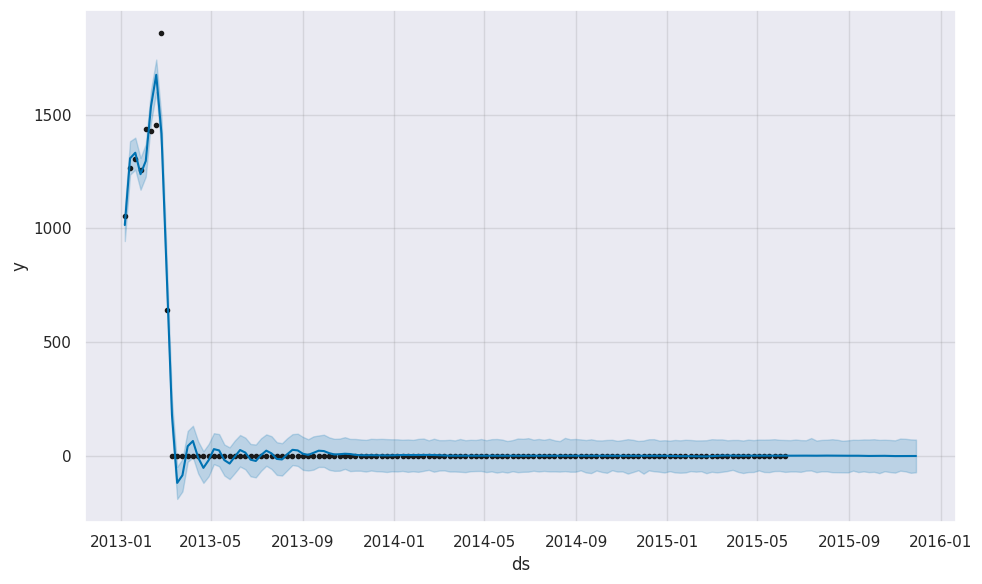

In [236]:
prophet_id_0['model'].plot(prophet_id_0['forecast']);

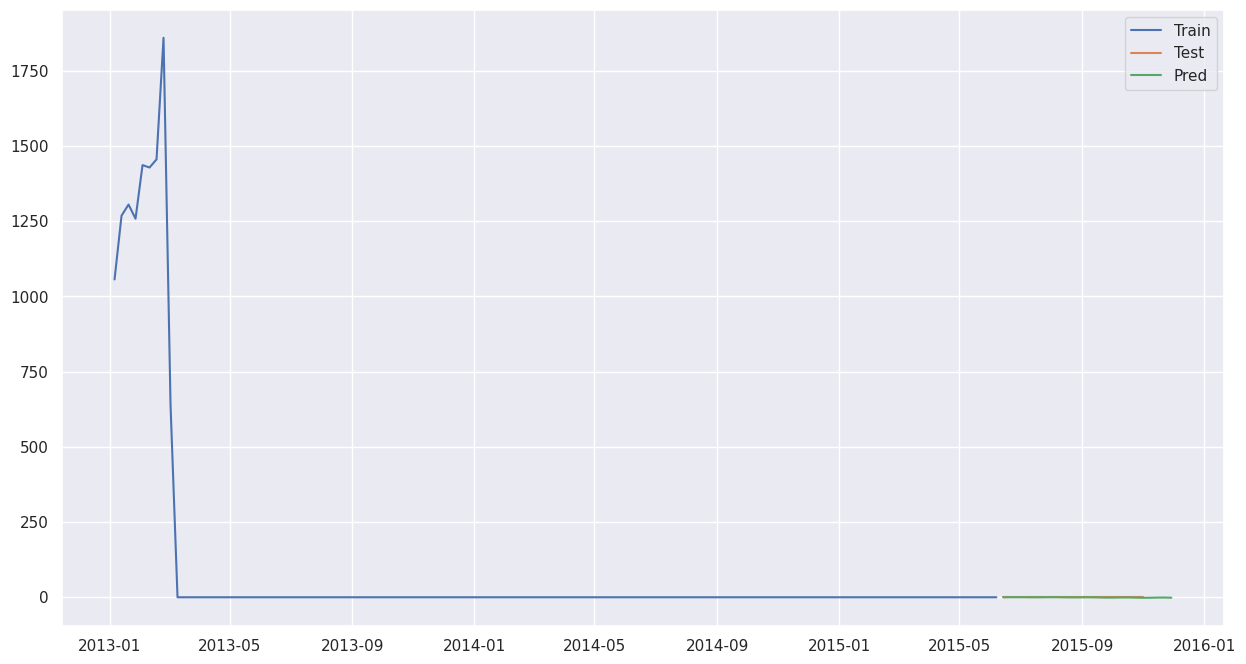

In [242]:
plot_forecast(prophet_id_0)

In [243]:
prophet_id_10['forecast'].tail(4)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
148,2015-11-08,100.071988,62.162958,174.339751,100.054093,100.089219,0.175090,0.175090,0.175090,0.175090,0.175090,0.175090,0.0,0.0,0.0,117.593596
149,2015-11-15,99.143000,63.880605,182.412286,99.123917,99.161241,0.248984,0.248984,0.248984,0.248984,0.248984,0.248984,0.0,0.0,0.0,123.828052
150,2015-11-22,98.214012,62.054711,181.348885,98.193866,98.233084,0.245005,0.245005,0.245005,0.245005,0.245005,0.245005,0.0,0.0,0.0,122.276943
151,2015-11-29,97.285025,56.223644,169.954362,97.263336,97.305231,0.195345,0.195345,0.195345,0.195345,0.195345,0.195345,0.0,0.0,0.0,116.289164


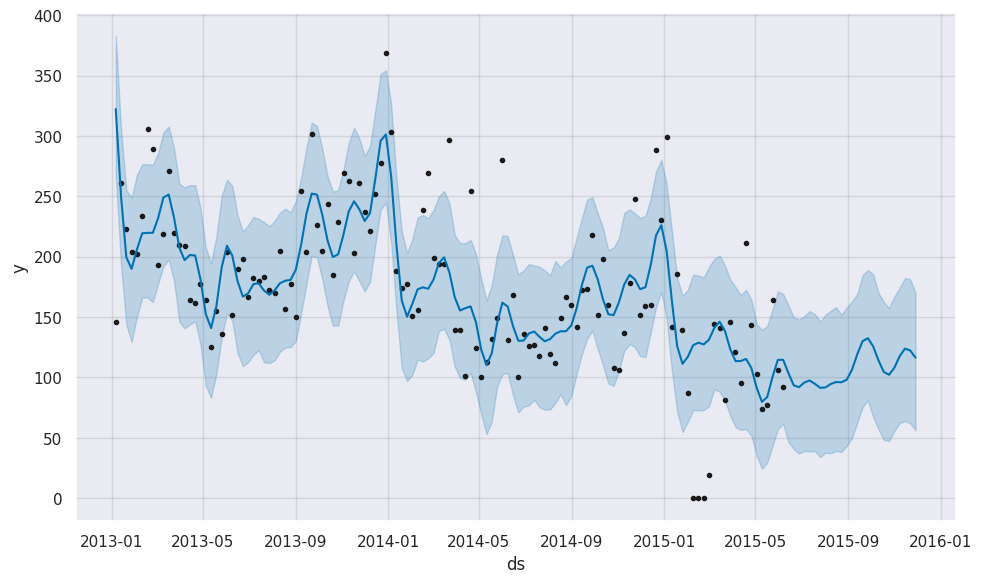

In [244]:
prophet_id_10['model'].plot(prophet_id_10['forecast']);

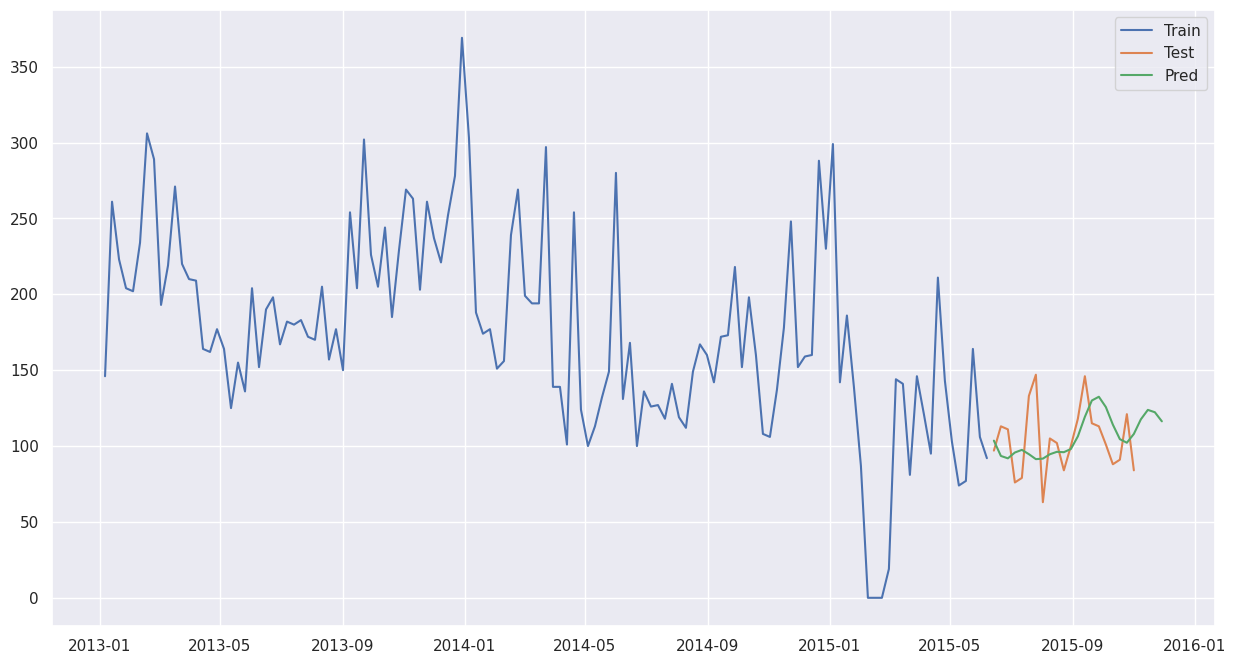

In [245]:
plot_forecast(prophet_id_10)

## Category

# Data Old and What?

## one

In [ ]:
sales_df.sample(10)

In [ ]:
sales_df.describe()

In [ ]:
sales_df.item_cnt_day.nunique()

In [ ]:
open_shops = np.sort(test_df['shop_id'].unique())
open_shops

In [ ]:
test_df.nunique()

In [ ]:
print("Categories:", categories_df.shape)
print("Items:", items_df.shape)
print("Shops:", shops_df.shape)
print("Sales:", sales_df.shape)
print("Test:", test_df.shape)
print("Sample:", sample_df.shape)

In [ ]:
# Total shop * itens, diff with sample
total = items_df.shape[0] * shops_df.shape[0]
print("Total shop * itens:", total)
print("Diffrence with the smple:", total - sample_df.shape[0])

In [ ]:
sales_df.dtypes

In [ ]:
sales_df

In [ ]:
shops_sales_month = pd.pivot_table(
    sales_df, values='item_cnt_day',
    index=['shop_id', 'item_id'], columns=['date_block_num'],
    aggfunc=np.sum 
)
shops_sales_month.fillna(0, inplace=True)
shops_sales_month.reset_index(inplace=True)

In [ ]:
shops_sales_month

In [ ]:
shops_sales_month['final_id'] = shops_sales_month['shop_id'].astype(str) + "-" + shops_sales_month['item_id'].astype(str)
shops_sales_month.set_index('final_id', inplace=True)
shops_sales_month.drop(columns=['shop_id', 'item_id'], inplace=True)
shops_sales_month = shops_sales_month.T

In [ ]:
shops_sales_month

In [ ]:
plot_cols = ['0-32', '0-49', '59-22144', '59-22167']
plot_features = shops_sales_month[plot_cols]
plot_features.index = shops_sales_month.index
plot_features.plot(subplots = True);

## two

In [ ]:
sales_df[sales_df['shop_id'] == 10].sort_values("date").groupby(by='date').sum('item_cnt_day')

In [ ]:
shop_sales_month =pd.DataFrame({"date_block_num": range(34)})
type(shop_sales_month)

In [ ]:
total_month_dict = {}
for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].groupby(by='date_block_num').sum('item_cnt_day')
    total_month_dict[shop_id] = df.shape[0]
    shop_sales_month[shop_id] = df.item_cnt_day
shop_sales_month.fillna(0, inplace=True)
shop_sales_month.drop(columns=['date_block_num'], inplace=True)

In [ ]:
shop_sales_month

In [ ]:
closed_shops = shop_sales_month.iloc[31:34]
closed_shops = pd.DataFrame(shop_sales_month.iloc[31:34].sum()).T
closed_shops

In [ ]:
pd.DataFrame(shop_sales_month.iloc[31:34].sum()).head(60)

In [ ]:
plt.plot(shop_sales_month.shop_id_0)
plt.plot(shop_sales_month.shop_id_1)
plt.plot(shop_sales_month.shop_id_8)
plt.plot(shop_sales_month.shop_id_9)

plt.plot(shop_sales_month.shop_id_11)
plt.plot(shop_sales_month.shop_id_13)
plt.plot(shop_sales_month.shop_id_17)
plt.plot(shop_sales_month.shop_id_20)
plt.plot(shop_sales_month.shop_id_23)
plt.plot(shop_sales_month.shop_id_27)

plt.plot(shop_sales_month.shop_id_29)
plt.plot(shop_sales_month.shop_id_30)
plt.plot(shop_sales_month.shop_id_32)
plt.plot(shop_sales_month.shop_id_33)
plt.plot(shop_sales_month.shop_id_40)
plt.plot(shop_sales_month.shop_id_27)


plt.plot(shop_sales_month.shop_id_43)
plt.plot(shop_sales_month.shop_id_51)
plt.plot(shop_sales_month.shop_id_54)
plt.plot(range(34))

In [ ]:
plt.plot(shop_sales_month.shop_id_27)
#plt.plot(shop_sales_month.shop_id_41)
#plt.plot(shop_sales_month.shop_id_42)
#plt.plot(shop_sales_month.shop_id_43)
#plt.plot(shop_sales_month.shop_id_44)
#plt.plot(shop_sales_month.shop_id_45)
#plt.plot(shop_sales_month.shop_id_46)

In [ ]:
sns.displot(total_month_dict, bins=34)
plt.xlim(1, 35, )

In [ ]:
total_month_dict

In [ ]:
open_shops